In [2]:
# Google Driveと接続を行います。これを行うことで、Driveにあるデータにアクセスできるようになります。
# 下記セルを実行すると、Googleアカウントのログインを求められますのでログインしてください。
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 作業フォルダへの移動を行います。
# 人によって作業場所が異なるので、その場合作業場所を変更してください。
import os
os.chdir('/content/drive/MyDrive/コンペ/参加中コンペ') #ここを変更。

In [4]:
pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.3/344.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.26.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.1 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.1 whic

In [5]:
pip install feature-engine

In [885]:
import pandas as pd
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submit.csv',index_col=0, header=None)
train.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,200,9,125,74,0,0,28.536910,0.444902,45,1
1,3832,4,109,80,0,0,28.047673,0.238243,22,0
2,4927,4,88,78,39,0,52.371341,0.279471,26,0
3,4088,9,125,74,0,0,40.062688,0.203922,45,0
4,3644,5,107,78,44,284,52.935068,0.284959,45,1


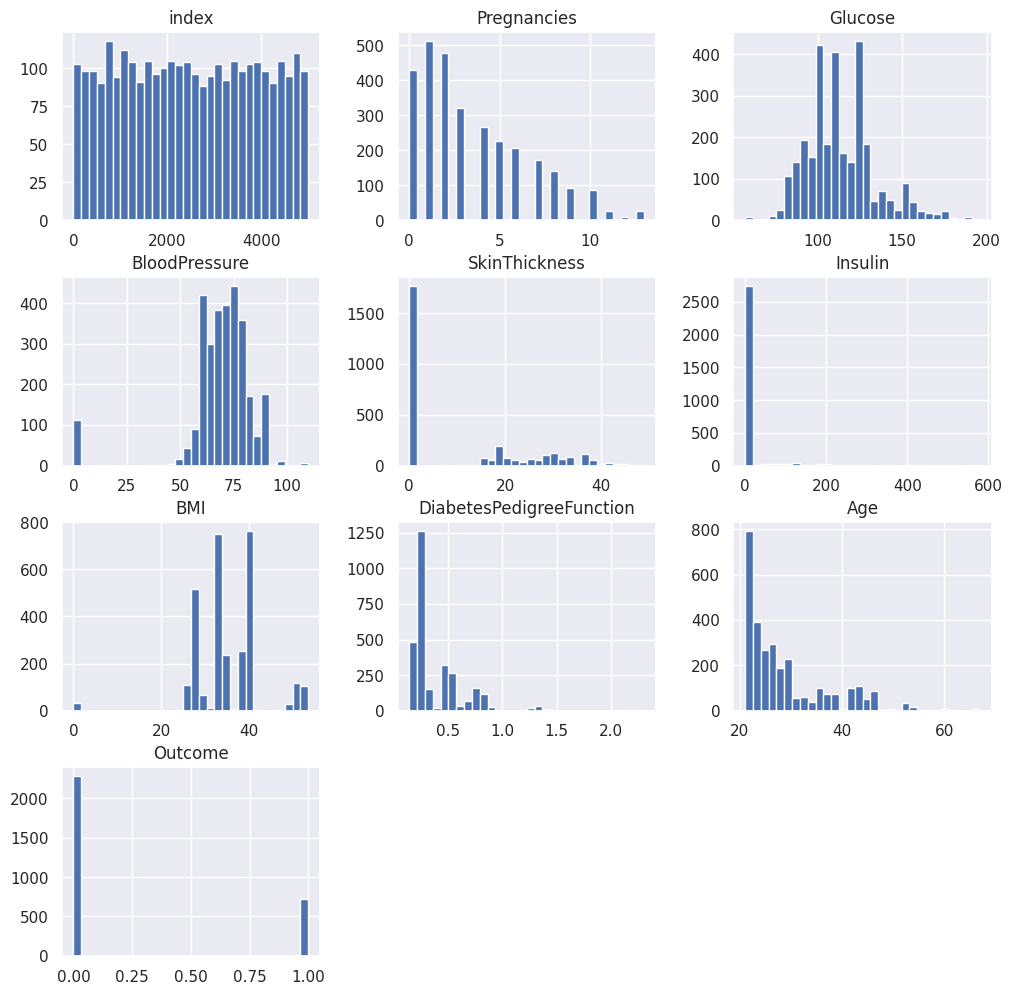

In [886]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.datasets import fetch_california_housing
train.hist(bins=30,figsize=(12,12))
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


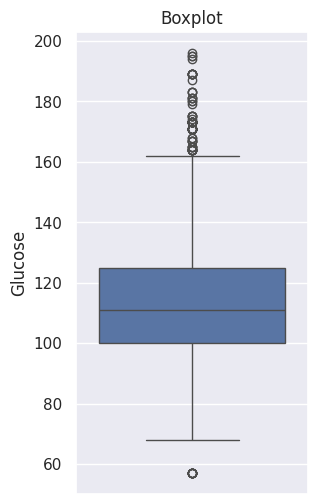

In [887]:
import seaborn as sns
sns.set(style="darkgrid")
from sklearn.datasets import fetch_california_housing

#図のサイズを表している
plt.figure(figsize=(3,6))
#箱ひげ図を作成すると書いてある
sns.boxplot(y=train["Glucose"])
plt.title("Boxplot")
plt.show()

In [888]:
def plot_boxplot_and_hist(data,variable):
  #2つのMatplotlib.Axesからなる図(ax_boxとax_hist)
  #plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)}) は、高さの比率が (0.50, 0.85) である2つのサブプロットを持つFigureオブジェクトを作成します。一方のサブプロットは箱ひげ図（ax_box）であり、もう一方はヒストグラム（ax_hist）です。sharex=True は、x軸を共有することを意味します。つまり、両方のサブプロットが同じx軸を共有します。
  #f, (ax_box, ax_hist) = ... のようにして、戻り値を f という変数に代入しています。これにより、作成された図全体 (f) とそれぞれのサブプロット (ax_box と ax_hist) にアクセスできます。
  f,(ax_box,ax_hist)=plt.subplots(2,sharex=True,
  gridspec_kw={"height_ratios":(0.50,0.85)})

  #グラフをそれぞれの軸に割り当てる
  #ヒストグラムと箱ひげ図の2つを作成している。またax=ax_boxとすることによってどこに描画するのかを決めている。
  sns.boxplot(x=data[variable],ax=ax_box)
  sns.histplot(data=data,x=variable,ax=ax_hist)

  #箱ひげ図のx軸のラベルを削除する
  ax_box.set(xlabel="")
  plt.title(variable)
  plt.show()

In [889]:
def find_limits(df,variable,fold):
  IQR = df[variable].quantile(0.75)-df[variable].quantile(0.25)
  lower_limit = df[variable].quantile(0.25)-(IQR*fold)
  upper_limit = df[variable].quantile(0.75)+(IQR*fold)
  return lower_limit,upper_limit

In [890]:
lower_limit,upper_limit = find_limits(train , "Glucose",2)
print(lower_limit,upper_limit)

50.0 175.0


In [891]:
outliers = np.where((train["Glucose"]>upper_limit) | (train["Glucose"]<lower_limit),True,False,)
outliers.sum()

21

In [892]:
from feature_engine.outliers import Winsorizer
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [893]:
breast_cancer = load_breast_cancer()
X = pd.DataFrame(breast_cancer.data,columns=breast_cancer.feature_names)
y = breast_cancer.target

In [894]:
def diagnostic_plots(df,variable):
  #図のサイズ
  plt.figure(figsize=(15,6))

  #作成された図をどの位置に表示するのかということを意味する。
  #1行2列のグリッドにおいて、1行目の左側（つまり1番目の位置）にサブプロットを配置することを意味します。
  plt.subplot(1,2,1)
  df[variable].value_counts().sort_index().plot.bar()
  plt.title(f"Hitogram of {variable}")

  plt.subplot(1,2,2)
  #variableというデータ実際の図と、正規分布の場合の図をプロットしている
  stats.probplot(df[variable],dist="norm",plot=plt)
  plt.title(f"Q-Q plot of {variable}")

  plt.show

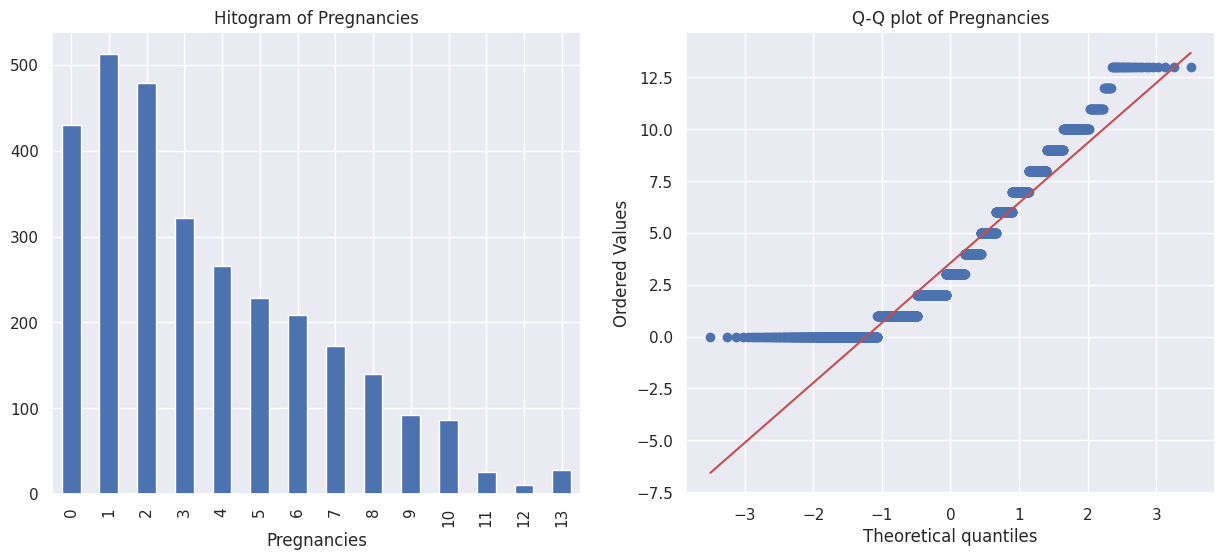

In [895]:
diagnostic_plots(train,"Pregnancies")

In [896]:
def diagnostic_plots(df,variable):
  #図のサイズ
  plt.figure(figsize=(15,6))

  #作成された図をどの位置に表示するのかということを意味する。
  #1行2列のグリッドにおいて、1行目の左側（つまり1番目の位置）にサブプロットを配置することを意味します。
  plt.subplot(1,2,1)
  df[variable].hist(bins=30)
  plt.title(f"Hitogram of {variable}")

  plt.subplot(1,2,2)
  #variableというデータ実際の図と、正規分布の場合の図をプロットしている
  stats.probplot(df[variable],dist="norm",plot=plt)
  plt.title(f"Q-Q plot of {variable}")

  plt.show

In [897]:
train_x=train.drop(["Outcome"],axis=1)
train_y=train["Outcome"]
test_x = test.copy()

In [898]:
#相関関係の確認
train.corrwith(train["Outcome"])

index                       0.010270
Pregnancies                 0.197909
Glucose                     0.064677
BloodPressure               0.051347
SkinThickness               0.001112
Insulin                     0.079457
BMI                         0.244350
DiabetesPedigreeFunction    0.099075
Age                         0.266000
Outcome                     1.000000
dtype: float64

In [899]:
train_x = train_x.drop(["index"],axis=1)
test_x = test_x.drop(["index"],axis=1)

In [900]:
lower_limit,upper_limit = find_limits(train_x,"Glucose",2)
lower_limit,upper_limit

(50.0, 175.0)

In [901]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)
t_train_x = poly.fit_transform(train_x)
t_test_x = poly.fit_transform(test_x)
t_train_x

array([[   9.        ,  125.        ,   74.        , ...,   12.69613342,
        1284.1609653 ,   20.02059778],
       [   4.        ,  109.        ,   80.        , ...,    6.68215629,
         617.04881128,    5.24134167],
       [   4.        ,   88.        ,   78.        , ...,   14.6362812 ,
        1361.65486548,    7.26625104],
       ...,
       [   6.        ,  117.        ,   96.        , ...,   20.12430787,
         618.23621684,   15.75476289],
       [   2.        ,  113.        ,   74.        , ...,    8.80493009,
        1257.00278584,   10.11478988],
       [   2.        ,  108.        ,   80.        , ...,    7.97249966,
         725.33116238,    5.31990081]])

In [902]:
poly.get_feature_names_out()

array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age',
       'Pregnancies Glucose', 'Pregnancies BloodPressure',
       'Pregnancies SkinThickness', 'Pregnancies Insulin',
       'Pregnancies BMI', 'Pregnancies DiabetesPedigreeFunction',
       'Pregnancies Age', 'Glucose BloodPressure',
       'Glucose SkinThickness', 'Glucose Insulin', 'Glucose BMI',
       'Glucose DiabetesPedigreeFunction', 'Glucose Age',
       'BloodPressure SkinThickness', 'BloodPressure Insulin',
       'BloodPressure BMI', 'BloodPressure DiabetesPedigreeFunction',
       'BloodPressure Age', 'SkinThickness Insulin', 'SkinThickness BMI',
       'SkinThickness DiabetesPedigreeFunction', 'SkinThickness Age',
       'Insulin BMI', 'Insulin DiabetesPedigreeFunction', 'Insulin Age',
       'BMI DiabetesPedigreeFunction', 'BMI Age',
       'DiabetesPedigreeFunction Age'], dtype=object)

In [903]:
t_train_x = pd.DataFrame(t_train_x,columns=poly.get_feature_names_out())
t_test_x = pd.DataFrame(t_test_x,columns=poly.get_feature_names_out())

In [904]:
check = t_train_x
t_train_x["Outcome"] = train["Outcome"]

In [905]:
t_train_x.corrwith(t_train_x["Outcome"])

Pregnancies                               0.197909
Glucose                                   0.064677
BloodPressure                             0.051347
SkinThickness                             0.001112
Insulin                                   0.079457
BMI                                       0.244350
DiabetesPedigreeFunction                  0.099075
Age                                       0.266000
Pregnancies Glucose                       0.207831
Pregnancies BloodPressure                 0.207467
Pregnancies SkinThickness                 0.129580
Pregnancies Insulin                       0.100084
Pregnancies BMI                           0.241786
Pregnancies DiabetesPedigreeFunction      0.199663
Pregnancies Age                           0.244307
Glucose BloodPressure                     0.073341
Glucose SkinThickness                     0.013563
Glucose Insulin                           0.081037
Glucose BMI                               0.226479
Glucose DiabetesPedigreeFunctio

In [906]:
high_correlation_columns = []
corr_series = t_train_x.corrwith(t_train_x["Outcome"])
#corr_series.items()によってカラム名と値を取り出している
for column, correlation in corr_series.items():
    if abs(correlation) > 0.2:  # 絶対値が0.2よりも大きい場合
        high_correlation_columns.append(column)
OK = [ 'Pregnancies Glucose',
 'Pregnancies BloodPressure',
 'Pregnancies BMI',
 'Pregnancies Age',
 'Glucose BMI',
 'Glucose Age',
 'BloodPressure BMI',
 'BloodPressure Age',
 'BMI Age']
OK

['Pregnancies Glucose',
 'Pregnancies BloodPressure',
 'Pregnancies BMI',
 'Pregnancies Age',
 'Glucose BMI',
 'Glucose Age',
 'BloodPressure BMI',
 'BloodPressure Age',
 'BMI Age']

In [907]:
o_train_x = train_x.copy()
o_test_x = test_x.copy()
o2_train_x = train_x.copy()
o2_test_x = test_x.copy()

In [908]:
o_train_x["Glucose"].clip(lower=lower_limit,upper=upper_limit,inplace=True)
o_test_x["Glucose"].clip(lower=lower_limit,upper=upper_limit,inplace=True)
o_train_x["Glucose"].min(),o_train_x["Glucose"].max()

<ipython-input-908-7433ae4e28c4>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  o_train_x["Glucose"].clip(lower=lower_limit,upper=upper_limit,inplace=True)
<ipython-input-908-7433ae4e28c4>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

(57, 175)

In [909]:
lower_limit,upper_limit = find_limits(train_x,"BloodPressure",2)
lower_limit,upper_limit

(36.0, 106.0)

In [910]:
"""o_train_x["BloodPressure"].clip(lower=lower_limit,upper=upper_limit,inplace=True)
o_test_x["BloodPressure"].clip(lower=lower_limit,upper=upper_limit,inplace=True)
o_train_x["BloodPressure"].min(),o_train_x["BloodPressure"].max()"""

'o_train_x["BloodPressure"].clip(lower=lower_limit,upper=upper_limit,inplace=True)\no_test_x["BloodPressure"].clip(lower=lower_limit,upper=upper_limit,inplace=True)\no_train_x["BloodPressure"].min(),o_train_x["BloodPressure"].max()'

In [911]:
OK

['Pregnancies Glucose',
 'Pregnancies BloodPressure',
 'Pregnancies BMI',
 'Pregnancies Age',
 'Glucose BMI',
 'Glucose Age',
 'BloodPressure BMI',
 'BloodPressure Age',
 'BMI Age']

In [912]:
ok_train_x = o_train_x.copy()
ok_test_x = o_test_x.copy()
ok_train_x['Pregnancies BMI'] = t_train_x['Pregnancies BMI']
ok_test_x['Pregnancies BMI'] = t_test_x['Pregnancies BMI']

In [913]:
lower_limit,upper_limit = find_limits(ok_train_x,"Pregnancies BMI",2)
lower_limit,upper_limit
ok_train_x["Pregnancies BMI"].clip(lower=lower_limit,upper=upper_limit,inplace=True)
ok_test_x["Pregnancies BMI"].clip(lower=lower_limit,upper=upper_limit,inplace=True)
ok_train_x["Pregnancies BMI"].min(),ok_train_x["Pregnancies BMI"].max()

<ipython-input-913-0ab8ea0577e7>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ok_train_x["Pregnancies BMI"].clip(lower=lower_limit,upper=upper_limit,inplace=True)
<ipython-input-913-0ab8ea0577e7>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

(0.0, 513.6405432125)

In [914]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [915]:
"""tree_train_x = poly.fit_transform(train_x)
tree_test_x = poly.fit_transform(test_x)"""
"""
"max_depth"は、XGBoostなどの決定木ベースのモデルのハイパーパラメータの1つであり、木の深さを指定します。
木の深さが深いほどモデルの複雑性が増し、過学習の可能性が高まります。
"""
param_grid = {"max_depth":[2,3,4,None]}
tree_model = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    cv=5,
    scoring="accuracy",
    param_grid=param_grid,
)

In [916]:
ok_train_x.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies BMI
0,9,125,74,0,0,28.536910,0.444902,45,256.832193
1,4,109,80,0,0,28.047673,0.238243,22,112.190693
2,4,88,78,39,0,52.371341,0.279471,26,209.485364
3,9,125,74,0,0,40.062688,0.203922,45,360.564192
4,5,107,78,44,284,52.935068,0.284959,45,264.675339


In [917]:
train_y.head()

0    1
1    0
2    0
3    0
4    1
Name: Outcome, dtype: int64

In [918]:
"""variables = ["Age","Glucose"]
variables = ["Pregnancies","SkinThickness"]"""
variables = ["Insulin","Pregnancies"]
tree_model.fit(ok_train_x[variables],train_y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, None]}, scoring='accuracy')

In [919]:
ok2_train_x=ok_train_x.copy()
ok2_test_x=ok_test_x.copy()

In [920]:
ok2_train_x["new_feat"] = tree_model.predict(ok_train_x[variables])
ok2_test_x["new_feat"] = tree_model.predict(ok_test_x[variables])

In [921]:
"""from sklearn.preprocessing import StandardScaler
# 学習データに基づいて複数列の標準化を定義
scaler = StandardScaler()
scaler.fit(train_x)
scaler.fit(test_x)
# 変換後のデータで各列を置換
st_train_x = scaler.transform(train_x)
st_test_x = scaler.transform(test_x)

st_train_x=pd.DataFrame(st_train_x, columns=train_x.columns, index=train_x.index)
st_test_x=pd.DataFrame(st_test_x, columns=test_x.columns, index=test_x.index)"""

'from sklearn.preprocessing import StandardScaler\n# 学習データに基づいて複数列の標準化を定義\nscaler = StandardScaler()\nscaler.fit(train_x)\nscaler.fit(test_x)\n# 変換後のデータで各列を置換\nst_train_x = scaler.transform(train_x)\nst_test_x = scaler.transform(test_x)\n\nst_train_x=pd.DataFrame(st_train_x, columns=train_x.columns, index=train_x.index)\nst_test_x=pd.DataFrame(st_test_x, columns=test_x.columns, index=test_x.index)'

In [922]:
"""test_x2=test_x.copy()
train_x2=train_x.copy()
train_x2["Pregnancies BMI"] = ok_train_x["Pregnancies BMI"]
test_x2["Pregnancies BMI"] = ok_test_x["Pregnancies BMI"]
# 変換後のデータで各列を置換
train_x2['SkinThickness'] = np.log1p(train_x2['SkinThickness'])
train_x2['Insulin'] = np.log1p(train_x2['Insulin'])
train_x2['Age'] = np.log1p(train_x2['Age'])
train_x2['DiabetesPedigreeFunction'] = np.log1p(train_x2['DiabetesPedigreeFunction'])
train_x2['Pregnancies BMI'] = np.log1p(train_x2['Pregnancies BMI'])
test_x2['SkinThickness'] = np.log1p(test_x2['SkinThickness'])
test_x2['Insulin'] = np.log1p(test_x2['Insulin'])
test_x2['Age'] = np.log1p(test_x2['Age'])
test_x2['DiabetesPedigreeFunction'] = np.log1p(test_x2['DiabetesPedigreeFunction'])
test_x2['Pregnancies BMI'] = np.log1p(test_x2['Pregnancies BMI'])"""

'test_x2=test_x.copy()\ntrain_x2=train_x.copy()\ntrain_x2["Pregnancies BMI"] = ok_train_x["Pregnancies BMI"]\ntest_x2["Pregnancies BMI"] = ok_test_x["Pregnancies BMI"]\n# 変換後のデータで各列を置換\ntrain_x2[\'SkinThickness\'] = np.log1p(train_x2[\'SkinThickness\'])\ntrain_x2[\'Insulin\'] = np.log1p(train_x2[\'Insulin\'])\ntrain_x2[\'Age\'] = np.log1p(train_x2[\'Age\'])\ntrain_x2[\'DiabetesPedigreeFunction\'] = np.log1p(train_x2[\'DiabetesPedigreeFunction\'])\ntrain_x2[\'Pregnancies BMI\'] = np.log1p(train_x2[\'Pregnancies BMI\'])\ntest_x2[\'SkinThickness\'] = np.log1p(test_x2[\'SkinThickness\'])\ntest_x2[\'Insulin\'] = np.log1p(test_x2[\'Insulin\'])\ntest_x2[\'Age\'] = np.log1p(test_x2[\'Age\'])\ntest_x2[\'DiabetesPedigreeFunction\'] = np.log1p(test_x2[\'DiabetesPedigreeFunction\'])\ntest_x2[\'Pregnancies BMI\'] = np.log1p(test_x2[\'Pregnancies BMI\'])'

In [926]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss , accuracy_score
import xgboost as xgb
from sklearn.metrics import log_loss
import numpy as np
from sklearn.metrics import log_loss , accuracy_score

scores_accuracy = []
scores_logloss =[]
#クロスバリデーションを行う
#学習データを4分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す
kf=KFold(n_splits=4 , shuffle=True , random_state = 71)
for tr_idx,va_idx in kf.split(o_train_x):
  #学習データを学習データとバリデーションデータに分ける
  tr_x,va_x=o_train_x.iloc[tr_idx],o_train_x.iloc[va_idx]
  tr_y,va_y=train_y.iloc[tr_idx],train_y.iloc[va_idx]
  #特徴量と目的変数をxgboostのデータ構造に変換する
  dtrain = xgb.DMatrix(tr_x,label=tr_y)
  dvalid = xgb.DMatrix(va_x, label = va_y)
  dtest = xgb.DMatrix(o_test_x)
  #ハイパーパラメータの設定
  #silent:1によってが学習中のメッセージを抑制するようになっている
  #random_stateをせっていすることによって再現性を保つことが出来るようにしている。
  params = {"objective": "binary:logistic","silent":1,"random_state":71}
  num_round = 50;

  watchlist = [(dtrain,"train"),(dvalid,"eval")]
  model = xgb.train(params,dtrain,num_round,evals=watchlist)

  va_pred = model.predict(dvalid)
  #loglossはロジスティック損失を表しており、ロジスティック損失は、確率予測の正確さを測るための指標のひとつで、誤差が大きいほど損失が指数関数的に大きくなる特徴があります。
  score = log_loss(va_y,va_pred)
  accuracy = accuracy_score(va_y,va_pred>0.5)
  scores_logloss.append(score)
  scores_accuracy.append(accuracy)

print(f"logloss:{np.mean(scores_logloss):.4f}")
print(f"accuracy:{np.mean(scores_accuracy):.4f}")

pred = model.predict(dtest)
pred_label=np.where(pred>0.5,1,0)
"""
logloss:0.4685
accuracy:0.8027
"""

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:47:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.48523	eval-logloss:0.51008
[1]	train-logloss:0.43894	eval-logloss:0.48637
[2]	train-logloss:0.41061	eval-logloss:0.46926
[3]	train-logloss:0.38745	eval-logloss:0.45673
[4]	train-logloss:0.36352	eval-logloss:0.44576
[5]	train-logloss:0.34882	eval-logloss:0.44179
[6]	train-logloss:0.33344	eval-logloss:0.44100
[7]	train-logloss:0.32050	eval-logloss:0.43882
[8]	train-logloss:0.30989	eval-logloss:0.43906
[9]	train-logloss:0.30370	eval-logloss:0.43856
[10]	train-logloss:0.29270	eval-logloss:0.43743
[11]	train-logloss:0.28553	eval-logloss:0.43529
[12]	train-logloss:0.27885	eval-logloss:0.43607
[13]	train-logloss:0.27409	eval-logloss:0.43485
[14]	train-logloss:0.26410	eval-logloss:0.43446
[15]	train-logloss:0.25680	eval-logloss:0.43374
[16]	train-logloss:0.25170	eval-logloss:0.43329
[17]	train-logloss:0.24278	eval-logloss:0.43192
[18]	train-logloss:0.23803	eval-logloss:0.43410
[19]	train-logloss:0.23409	eval-logloss:0.43337
[20]	train-logloss:0.23036	eval-logloss:0.43231
[2

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:47:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	train-logloss:0.44819	eval-logloss:0.46798
[2]	train-logloss:0.41844	eval-logloss:0.45648
[3]	train-logloss:0.39605	eval-logloss:0.44810
[4]	train-logloss:0.37637	eval-logloss:0.44209
[5]	train-logloss:0.36085	eval-logloss:0.43956
[6]	train-logloss:0.34287	eval-logloss:0.43150
[7]	train-logloss:0.33399	eval-logloss:0.42902
[8]	train-logloss:0.32407	eval-logloss:0.42658
[9]	train-logloss:0.31532	eval-logloss:0.42778
[10]	train-logloss:0.30821	eval-logloss:0.42773
[11]	train-logloss:0.29869	eval-logloss:0.42678
[12]	train-logloss:0.28391	eval-logloss:0.42607
[13]	train-logloss:0.27438	eval-logloss:0.42667
[14]	train-logloss:0.26758	eval-logloss:0.42629
[15]	train-logloss:0.26170	eval-logloss:0.42643
[16]	train-logloss:0.25853	eval-logloss:0.42852
[17]	train-logloss:0.25461	eval-logloss:0.42930
[18]	train-logloss:0.24719	eval-logloss:0.43153
[19]	train-logloss:0.24061	eval-logloss:0.43378
[20]	train-logloss:0.23723	eval-logloss:0.43295
[21]	train-logloss:0.23391	eval-logloss:0.43262
[

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:47:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	train-logloss:0.21263	eval-logloss:0.42205
[29]	train-logloss:0.20978	eval-logloss:0.42307
[30]	train-logloss:0.20665	eval-logloss:0.42146
[31]	train-logloss:0.20322	eval-logloss:0.42221
[32]	train-logloss:0.20039	eval-logloss:0.42297
[33]	train-logloss:0.19791	eval-logloss:0.42373
[34]	train-logloss:0.19717	eval-logloss:0.42386
[35]	train-logloss:0.19361	eval-logloss:0.42496
[36]	train-logloss:0.19156	eval-logloss:0.42676
[37]	train-logloss:0.19020	eval-logloss:0.42863
[38]	train-logloss:0.18565	eval-logloss:0.43000
[39]	train-logloss:0.18437	eval-logloss:0.42899
[40]	train-logloss:0.18103	eval-logloss:0.43098
[41]	train-logloss:0.17544	eval-logloss:0.43504
[42]	train-logloss:0.17174	eval-logloss:0.43668
[43]	train-logloss:0.16874	eval-logloss:0.43566
[44]	train-logloss:0.16746	eval-logloss:0.43637
[45]	train-logloss:0.16367	eval-logloss:0.43946
[46]	train-logloss:0.16278	eval-logloss:0.43922
[47]	train-logloss:0.15848	eval-logloss:0.43982
[48]	train-logloss:0.15513	eval-logloss:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:47:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	train-logloss:0.21298	eval-logloss:0.49531
[25]	train-logloss:0.20772	eval-logloss:0.49554
[26]	train-logloss:0.20577	eval-logloss:0.49622
[27]	train-logloss:0.20282	eval-logloss:0.49855
[28]	train-logloss:0.19830	eval-logloss:0.50219
[29]	train-logloss:0.19262	eval-logloss:0.50395
[30]	train-logloss:0.18684	eval-logloss:0.50285
[31]	train-logloss:0.17986	eval-logloss:0.50674
[32]	train-logloss:0.17828	eval-logloss:0.50680
[33]	train-logloss:0.17716	eval-logloss:0.50756
[34]	train-logloss:0.17442	eval-logloss:0.50727
[35]	train-logloss:0.17216	eval-logloss:0.50697
[36]	train-logloss:0.17007	eval-logloss:0.50725
[37]	train-logloss:0.16344	eval-logloss:0.50822
[38]	train-logloss:0.15981	eval-logloss:0.51258
[39]	train-logloss:0.15754	eval-logloss:0.51272
[40]	train-logloss:0.15522	eval-logloss:0.51272
[41]	train-logloss:0.15388	eval-logloss:0.51326
[42]	train-logloss:0.15138	eval-logloss:0.51321
[43]	train-logloss:0.14858	eval-logloss:0.51566
[44]	train-logloss:0.14559	eval-logloss:

'\nlogloss:0.4616\naccuracy:0.8033\n'

In [924]:
"""from sklearn.linear_model import LogisticRegression
scores_accuracy = []
scores_logloss =[]
#クロスバリデーションを行う
#学習データを4分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す
kf=KFold(n_splits=4 , shuffle=True , random_state = 71)
for tr_idx,va_idx in kf.split(train_x2):
  #学習データを学習データとバリデーションデータに分ける
  tr_x,va_x=train_x2.iloc[tr_idx],train_x2.iloc[va_idx]
  tr_y,va_y=train_y.iloc[tr_idx],train_y.iloc[va_idx]
  model_lr=LogisticRegression(solver="lbfgs",max_iter=300)
  model_lr.fit(tr_x,tr_y)
  va_pred=model_lr.predict_proba(va_x)[:,1]

  #loglossはロジスティック損失を表しており、ロジスティック損失は、確率予測の正確さを測るための指標のひとつで、誤差が大きいほど損失が指数関数的に大きくなる特徴があります。
  score = log_loss(va_y,va_pred)
  accuracy = accuracy_score(va_y,va_pred>0.5)
  scores_logloss.append(score)
  scores_accuracy.append(accuracy)

print(f"logloss:{np.mean(scores_logloss):.4f}")
print(f"accuracy:{np.mean(scores_accuracy):.4f}")
#logloss:0.4807
#accuracy:0.7770"""

'from sklearn.linear_model import LogisticRegression\nscores_accuracy = []\nscores_logloss =[]\n#クロスバリデーションを行う\n#学習データを4分割し、うち1つをバリデーションデータとすることを、バリデーションデータを変えて繰り返す\nkf=KFold(n_splits=4 , shuffle=True , random_state = 71)\nfor tr_idx,va_idx in kf.split(train_x2):\n  #学習データを学習データとバリデーションデータに分ける\n  tr_x,va_x=train_x2.iloc[tr_idx],train_x2.iloc[va_idx]\n  tr_y,va_y=train_y.iloc[tr_idx],train_y.iloc[va_idx]\n  model_lr=LogisticRegression(solver="lbfgs",max_iter=300)\n  model_lr.fit(tr_x,tr_y)\n  va_pred=model_lr.predict_proba(va_x)[:,1]\n\n  #loglossはロジスティック損失を表しており、ロジスティック損失は、確率予測の正確さを測るための指標のひとつで、誤差が大きいほど損失が指数関数的に大きくなる特徴があります。\n  score = log_loss(va_y,va_pred)\n  accuracy = accuracy_score(va_y,va_pred>0.5)\n  scores_logloss.append(score)\n  scores_accuracy.append(accuracy)\n\nprint(f"logloss:{np.mean(scores_logloss):.4f}")\nprint(f"accuracy:{np.mean(scores_accuracy):.4f}")\n#logloss:0.4807\n#accuracy:0.7770'

In [925]:
from xgboost import XGBClassifier

model_xgb=XGBClassifier(n_estimators=20,random_state=71)
model_xgb.fit(ok_train_x,train_y)
pred_xgb=model_xgb.predict_proba(ok_test_x)[:,1]

pred=pred_xgb
pred_label=np.where(pred>0.5,1,0)
sample[1] = pred_label
sample.to_csv("submit.csv", header=None)